In [2]:
import dgl
%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os

import matplotlib.pyplot as plt
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

In [3]:
adj = np.load('../../../data/single_graph/caveman/graph_adj.npy')
rows, cols = np.where(adj == 1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges)

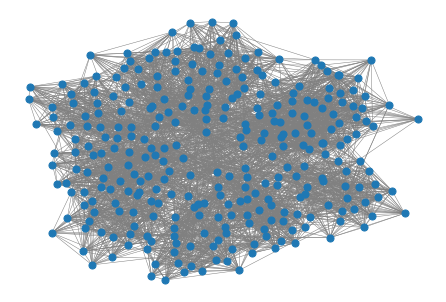

In [5]:
nx.draw(G, node_size=50, edge_color="gray", width=0.5)

In [6]:
labels = pd.read_csv('../../../data/single_graph/caveman/data.csv').label.values

In [13]:
import torch
features = np.zeros((labels.shape[0], 10))
for i in range(10):
    features[i*30 : i*30+30, i] = 1

In [8]:
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        if self.activation is not None:
            h = self.activation(h)
        return {'h' : h}
    
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [20]:
class Net(nn.Module):
    def __init__(self, in_feat, hidden_dim, out_cls):
        super(Net, self).__init__()
        self.gcn1 = GCN(in_feat, hidden_dim, F.relu)
        self.gcn2 = GCN(hidden_dim, out_cls, None)

    def forward(self, g, features):
        #features = g.in_degrees().view(-1, 1).float()
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x

In [15]:
S = dgl.DGLGraph()
S.from_networkx(G)
S.ndata['h'] = features

In [17]:
np.random.seed(1)
labeled_nodes = np.random.choice(list(range(G.number_of_nodes())), int(G.number_of_nodes() * 0.15), replace = False)
labels_train = labels[labeled_nodes]

unlabelled_nodes = [i for i in list(range(G.number_of_nodes())) if i not in labeled_nodes]
val_nodes = np.random.choice(unlabelled_nodes, int(len(unlabelled_nodes)*0.2), replace = False)
test_nodes = [i for i in unlabelled_nodes if i not in val_nodes]

val_label = labels[val_nodes]
test_label = labels[test_nodes]

In [37]:
net = Net(10, 64, 10)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(1000):
    logits = net(S, torch.Tensor(features).float())
    # we save the logits for visualization later
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], torch.LongTensor(labels_train))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))


Epoch 0 | Loss: 56.7629
Epoch 100 | Loss: 0.0000
Epoch 200 | Loss: 0.0000
Epoch 300 | Loss: 0.0000
Epoch 400 | Loss: 0.0000
Epoch 500 | Loss: 0.0000
Epoch 600 | Loss: 0.0000
Epoch 700 | Loss: 0.0000
Epoch 800 | Loss: 0.0000
Epoch 900 | Loss: 0.0000


In [40]:
net.eval()
logits = net(S, torch.Tensor(features).float())
# we save the logits for visualization later
logp = F.log_softmax(logits, 1)
# we only compute loss for labeled nodes
#loss = F.nll_loss(logp[labeled_nodes], labels_train)

In [41]:
argmax_Y = torch.max(logp[test_nodes], 1)[1]

In [43]:
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (torch.LongTensor(test_label) == argmax_Y.float()).sum().item() / len(test_label) * 100))

Accuracy of argmax predictions on the test set: 100.000000%
